# Imports and Functions

In [1]:
import pg8000          #pg8000 access SQL databases
import pandas as pd    #pandas will be needed to work in a dataframe
from pandas import ExcelWriter
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from scipy.stats import sem, t
from scipy import mean
sns.set(style='white', color_codes = True)

In [2]:
excel = pd.read_excel('//allen/programs/celltypes/workgroups/279/Pilot_work/channel_recordings/peak_current_data/channel_data.xlsx', sheet_name = 'peak_currents')

In [3]:
#code from Agata
#these are nice functions to open LIMS, make a query and then close LIMS after

def _connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    conn = pg8000.connect(user=user, host=host, database=database, password=password, port=port)
    return conn, conn.cursor()

def _select(cursor, query):
    cursor.execute(query)
    columns = [ d[0] for d in cursor.description ]
    return [ dict(zip(columns, c)) for c in cursor.fetchall() ]

def limsquery(query, user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432):
    """A function that takes a string containing a SQL query, connects to the LIMS database and outputs the result."""
    conn, cursor = _connect(user, host, database, password, port)
    try:
        results = _select(cursor, query)
    finally:
        
        #THESE ARE IMPORTANT!!!!!!
        #Every query needs to be closed when done
        cursor.close()             
        conn.close()
    return results


#this last function will take our query results and put them in a dataframe so that they are easy to work with
def get_lims_dataframe(query):
    '''Return a dataframe with lims query'''
    result = limsquery(query)
    try:
        data_df = pd.DataFrame(data=result, columns=result[0].keys())
    except IndexError:
        print "Could not find results for your query."
        data_df = pd.DataFrame()
    return data_df

# Morphology Analysis

In [4]:
query = "WITH do_63x(cell_id, go) AS (SELECT DISTINCT cell.id, array_to_string(array_agg(DISTINCT tag.name), ' _AND_ ') \
FROM specimens cell JOIN ephys_roi_results err ON err.id = cell.ephys_roi_result_id \
JOIN specimen_tags_specimens sptagsp ON sptagsp.specimen_id = cell.id \
JOIN specimen_tags tag ON tag.id = sptagsp.specimen_tag_id AND tag.id in (602120185,602122082) \
GROUP BY cell.id ORDER BY 1),\
swc as (select nr.specimen_id as cell_id, swc.storage_directory || swc.filename as swc_filename, marker.storage_directory || marker.filename as marker_filename, swc.published_at as published_at \
from neuron_reconstructions nr \
join well_known_files swc on swc.attachable_id = nr.id and swc.well_known_file_type_id = 303941301\
left join well_known_files marker on marker.attachable_id = nr.id and marker.well_known_file_type_id = 486753749\
where nr.superseded = false and nr.manual = true)\
SELECT s.patched_cell_container, err.recording_date,do_63x.go AS go_no_go_63x, ra.failed AS RNA_seq_QC_Failed, s.name, swc.swc_filename \
FROM specimens s \
LEFT JOIN projects proj ON s.project_id = proj.id \
LEFT JOIN swc on s.id = swc.cell_id \
LEFT JOIN do_63x ON do_63x.cell_id = s.id \
LEFT JOIN ephys_roi_results err ON s.ephys_roi_result_id = err.id \
LEFT JOIN rna_amplification_inputs rai on rai.sample_id = s.id \
LEFT JOIN rna_amplifications ra on ra.id = rai.rna_amplification_id \
WHERE proj.code <> 'mMPATCH' AND \
s.patched_cell_container IS NOT NULL"

lims_df = get_lims_dataframe(query)
lims_df.tail()

,go_no_go_63x,name,recording_date,swc_filename,rna_seq_qc_failed,patched_cell_container
13846,None,H17.06.003.13.01.04,2017-02-01 13:56:23,None,None,P2S4_170201_054_A01
13847,None,H19.03.311.13.05.01.01.01,NaT,None,None,PXS4_190514_401_A01
13848,None,H17.06.003.13.01.01,2017-02-01 11:06:41,None,None,P2S4_170201_051_A01
13849,None,Glt25d2-Cre_NF107;Ai14-461398.04.02.02,NaT,None,None,PAS4_190513_455_A01
13850,None,H19.03.311.14.08.01.01,NaT,None,None,P2S4_190514_051_A01


In [5]:
merged_df = pd.merge(left = excel, 
                    right = lims_df, 
                    left_on = 'cell', #excel
                    right_on = 'name', #lims
                    how = 'left')

short_merged_df = merged_df.loc[:,['cell','patched_cell_container','go_no_go_63x', 'swc_filename']]
#writer = pd.ExcelWriter('channel_recording_morpho_stats.xlsx')
short_merged_df.to_excel('channel_recording_morpho_stats.xlsx')
short_merged_df.head()

,cell,patched_cell_container,go_no_go_63x,swc_filename
0,Cck-IRES-Cre;Vip-IRES-FlpO;Ai65-417327.04.02.01,P8S4_181003_351_A01,63x go,None
1,Cck-IRES-Cre;Vip-IRES-FlpO;Ai65-417710.04.02.01,P8S4_181008_353_A01,63x go,None
2,Cck-IRES-Cre;Vip-IRES-FlpO;Ai65-417710.05.02.01,P8S4_181008_355_A01,63x no go,None
3,Cck-IRES-Cre;Vip-IRES-FlpO;Ai65-417711.02.02.01,P8S4_181009_354_A01,63x go,None
4,Cck-IRES-Cre;Vip-IRES-FlpO;Ai65-417711.03.02.01,P8S4_181009_353_A01,63x go,None


In [6]:
#short_merged_df.plot.pie(y='go_no_go_63x', figsize=(5,5))
short_merged_df['go_no_go_63x'].fillna('No call yet', inplace=True)

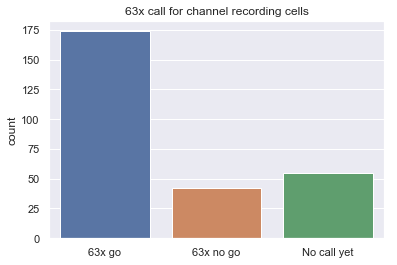

In [7]:
sns.set(style='darkgrid')
sns.countplot(x='go_no_go_63x', data=short_merged_df)
plt.title('63x call for channel recording cells')
plt.xlabel('')

In [8]:
today = datetime.today()
today_str = today.strftime('%Y-%m-%d')
today_str

'2019-05-15'

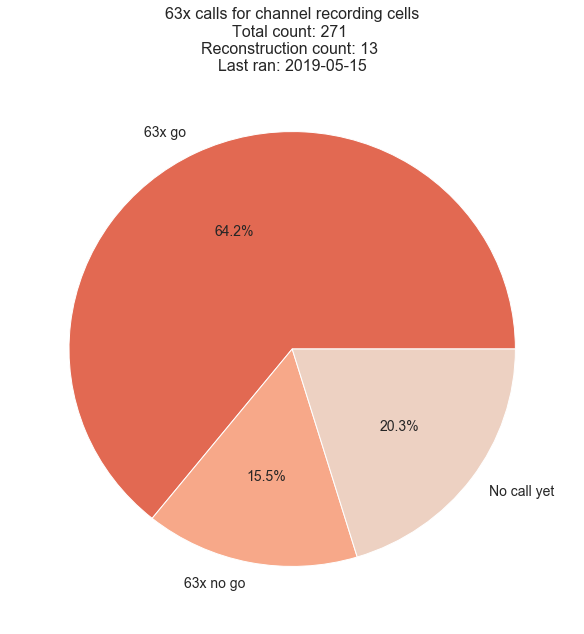

In [9]:
reconstructions = len(short_merged_df.groupby('swc_filename').count())
total = len(short_merged_df)
color = sns.color_palette("coolwarm_r")
short_merged_df.groupby('go_no_go_63x')['cell'].count().plot.pie(y= 'go_no_go_63x', autopct='%1.1f%%',figsize=(10,10), colors = color, fontsize =14)
plt.ylabel('')
plt.title('63x calls for channel recording cells\nTotal count: %d \nReconstruction count: %d \nLast ran: %s' %(total,reconstructions, today_str), fontsize = 16)
plt.savefig("C:/users/lindsayn/documents/github/analysis/figures/morphology_pie", dpi=100)

# Initial Rundown Analysis

In [10]:
rundown_data = pd.read_excel('//allen/programs/celltypes/workgroups/279/Pilot_work/channel_recordings/peak_current_data/channel_data.xlsx', sheet_name = 'rundown_data')
rundown_data.head()

,cell,peak_1,peak_2,peak_diff,seal_1,seal_2
0,Scnn1a-Tg1-Cre;Ai14-442954.04.02.02,772,681.133179,90.866821,791.208884,1777.778682
1,Slc17a6-IRES-Cre;Ai14-443197.04.02.03,808,696.083008,111.916992,4053.333519,2576.271361
2,Slc17a6-IRES-Cre;Ai14-443197.04.02.02,770,808.146790,-38.146790,1271.966519,1006.622394
3,Slc17a6-IRES-Cre;Ai14-443197.04.02.01,1089,1149.147949,-60.147949,800.000000,615.384688
4,Ndnf-IRES2-dgCre;Slc32a1-IRES2-FlpO;Ai65-44333...,1616,1646.950439,-30.950439,1093.525474,1717.514487


In [11]:
print "peak 1 avg: " + str(rundown_data['peak_1'].mean().round())
print "peak 2 avg: " + str(rundown_data['peak_2'].mean().round())
print "seal 1 avg: " + str(rundown_data['seal_1'].mean().round())
print "seal 2 avg: " + str(rundown_data['seal_2'].mean().round())

peak 1 avg: 1158.0
peak 2 avg: 1118.0
seal 1 avg: 2498.0
seal 2 avg: 2642.0


In [12]:
percent_peak_decrease = (rundown_data['peak_diff'] / rundown_data['peak_1']) * 100
rundown_data['percent_peak_decrease'] = percent_peak_decrease.round(2)
rundown_data.head()

,cell,peak_1,peak_2,peak_diff,seal_1,seal_2,percent_peak_decrease
0,Scnn1a-Tg1-Cre;Ai14-442954.04.02.02,772,681.133179,90.866821,791.208884,1777.778682,11.77
1,Slc17a6-IRES-Cre;Ai14-443197.04.02.03,808,696.083008,111.916992,4053.333519,2576.271361,13.85
2,Slc17a6-IRES-Cre;Ai14-443197.04.02.02,770,808.146790,-38.146790,1271.966519,1006.622394,-4.95
3,Slc17a6-IRES-Cre;Ai14-443197.04.02.01,1089,1149.147949,-60.147949,800.000000,615.384688,-5.52
4,Ndnf-IRES2-dgCre;Slc32a1-IRES2-FlpO;Ai65-44333...,1616,1646.950439,-30.950439,1093.525474,1717.514487,-1.92


In [13]:
confidence = 0.95
data = rundown_data['peak_diff']

n = len(data)
m = data.mean()
std_err = sem(data)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

start = m - h
end = m + h
print "95% confidence interval: " + str(start) + ',' + str(end)

95% confidence interval: 7.05760531977,72.8008298775


In [14]:
rundown_data['seal_diff'] = (rundown_data['seal_1'] - rundown_data['seal_2'])


In [15]:
confidence = 0.95
data = rundown_data['seal_diff']

n = len(data)
m = data.mean()
std_err = sem(data)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

start = m - h
end = m + h
print "95% confidence interval: " + str(start) + ',' + str(end)

95% confidence interval: -1347.85851622,1060.4585389


In [16]:
rundown_data.head()

,cell,peak_1,peak_2,peak_diff,seal_1,seal_2,percent_peak_decrease,seal_diff
0,Scnn1a-Tg1-Cre;Ai14-442954.04.02.02,772,681.133179,90.866821,791.208884,1777.778682,11.77,-986.569798
1,Slc17a6-IRES-Cre;Ai14-443197.04.02.03,808,696.083008,111.916992,4053.333519,2576.271361,13.85,1477.062158
2,Slc17a6-IRES-Cre;Ai14-443197.04.02.02,770,808.146790,-38.146790,1271.966519,1006.622394,-4.95,265.344125
3,Slc17a6-IRES-Cre;Ai14-443197.04.02.01,1089,1149.147949,-60.147949,800.000000,615.384688,-5.52,184.615312
4,Ndnf-IRES2-dgCre;Slc32a1-IRES2-FlpO;Ai65-44333...,1616,1646.950439,-30.950439,1093.525474,1717.514487,-1.92,-623.989013


In [17]:
rundown_data['peak_QC'] = abs(rundown_data['percent_peak_decrease']) < 10
rundown_data['peak_QC'] = rundown_data['peak_QC'].map({False: 'fail', True: 'pass'})
rundown_data

,cell,peak_1,peak_2,peak_diff,seal_1,seal_2,percent_peak_decrease,seal_diff,peak_QC
0,Scnn1a-Tg1-Cre;Ai14-442954.04.02.02,772,681.133179,90.866821,791.208884,1777.778682,11.77,-986.569798,fail
1,Slc17a6-IRES-Cre;Ai14-443197.04.02.03,808,696.083008,111.916992,4053.333519,2576.271361,13.85,1477.062158,fail
2,Slc17a6-IRES-Cre;Ai14-443197.04.02.02,770,808.146790,-38.146790,1271.966519,1006.622394,-4.95,265.344125,pass
3,Slc17a6-IRES-Cre;Ai14-443197.04.02.01,1089,1149.147949,-60.147949,800.000000,615.384688,-5.52,184.615312,pass
4,Ndnf-IRES2-dgCre;Slc32a1-IRES2-FlpO;Ai65-44333...,1616,1646.950439,-30.950439,1093.525474,1717.514487,-1.92,-623.989013,pass
5,Gad2-IRES-Cre;Ai14-444161.05.02.01,1458,537.075684,920.924316,422.809459,282.003960,63.16,140.805500,fail
6,Pvalb-IRES-Cre;Ai14-442765.04.02.01,4924,4495.164551,428.835449,2951.456562,3576.470508,8.71,-625.013946,pass
7,Gad2-IRES-Cre;Ai14-444161.05.02.02,957,913.633545,43.366455,1440.758049,1235.772120,4.53,204.985929,pass
8,Htr3a-Cre_NO152;Pvalb-T2A-FlpO;Ai65-445149.04....,2867,2758.830078,108.169922,4500.002199,1822.785268,3.77,2677.216932,pass
9,Htr3a-Cre_NO152;Ai14-445711.03.02.02,1203,1312.409424,-109.409424,2057.142633,3692.308126,-9.09,-1635.165493,pass


In [18]:
rundown_data['peak_QC'].value_counts()

pass    64
fail    24
Name: peak_QC, dtype: int64

In [19]:
rundown_data_high_seals = rundown_data[rundown_data['seal_1'] > 1000]

In [20]:
rundown_data_high_seals = rundown_data_high_seals[rundown_data_high_seals['seal_2'] > 1000]

In [21]:
rundown_data_high_seals['peak_QC'].value_counts()

pass    58
fail    16
Name: peak_QC, dtype: int64

In [22]:
rundown_data_high_seals[rundown_data_high_seals['peak_QC'] == 'fail']

,cell,peak_1,peak_2,peak_diff,seal_1,seal_2,percent_peak_decrease,seal_diff,peak_QC
1,Slc17a6-IRES-Cre;Ai14-443197.04.02.03,808,696.083008,111.916992,4053.333519,2576.271361,13.85,1477.062158,fail
10,Htr3a-Cre_NO152;Pvalb-T2A-FlpO;Ai65-445151.02....,1961,1701.679810,259.320190,2823.529158,1617.977584,13.22,1205.551575,fail
15,Vip-IRES-Cre;Ai14-445680.04.02.01,737,583.149475,153.850525,3891.891571,2249.999410,20.88,1641.892161,fail
17,Ctxn3-IRES2-FlpO-neo;Ai65F-445100.04.02.01,442,517.997681,-75.997681,2086.957214,2149.254661,-17.19,-62.297447,fail
30,Ctgf-T2A-dgCre;Ai14-450369.04.02.01,179,481.320251,-302.320251,2096.551338,2111.111089,-168.89,-14.559751,fail
31,Sst-IRES-Cre;Ai14-449979.02.02.01,592,307.907074,284.092926,1551.020589,1757.225953,47.99,-206.205363,fail
32,H19.06.351.11.06.01.01,473,387.996063,85.003937,1972.603585,1945.946327,17.97,26.657258,fail
38,H19.06.351.11.16.02.05,637,319.440735,317.559265,1358.490908,2526.315992,49.85,-1167.825084,fail
46,Nos1-CreERT2;Sst-IRES-FlpO;Ai65-452641.03.02.01,670,763.962341,-93.962341,2895.238148,3200.000488,-14.02,-304.762340,fail
50,Pvalb-IRES-Cre;Ai14-452732.03.02.01,2132,1908.495605,223.504395,1634.408723,2202.898624,10.48,-568.489901,fail


C:\Users\lindsayn\AppData\Local\Continuum\anaconda2\envs\channel_recordings\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


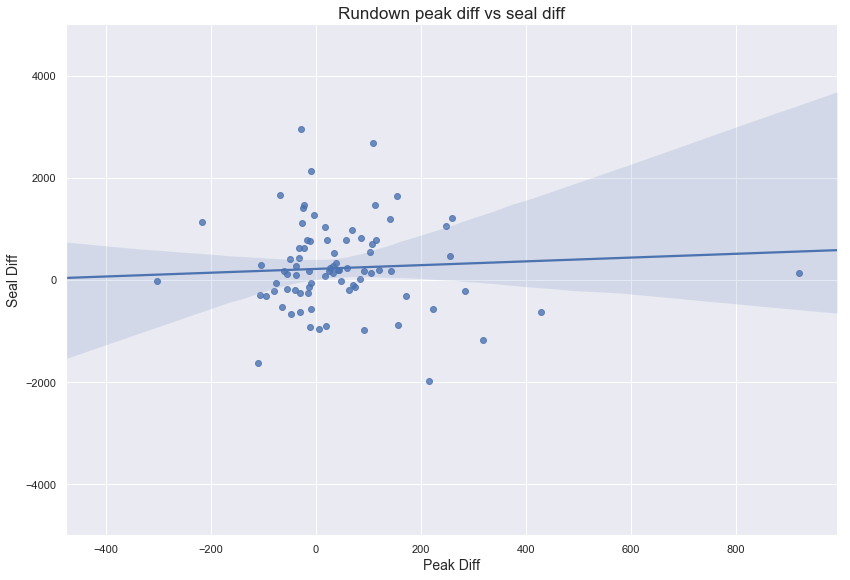

In [78]:
#fig, ax = plt.subplots(figsize=(14,10))
#sns.scatterplot(x="peak_diff", y="seal_diff", data=rundown_data, hue='peak_QC', legend='full',s=50)
sns.lmplot(x="peak_diff", y="seal_diff", data=rundown_data, size=8, legend=True, aspect=1.5, robust=True)
plt.title("Rundown peak diff vs seal diff", fontsize= 17, loc = "center")
plt.ylabel("Seal Diff", fontsize= 14)
plt.xlabel("Peak Diff", fontsize= 14)
#plt.gcf().subplots_adjust(top=0.92)
plt.ylim(-5000, 5000)
#plt.xlim(1, 6)
plt.savefig("C:/users/lindsayn/documents/github/analysis/figures/rundown_v_seal")

In [38]:
rundown_data

,cell,peak_1,peak_2,peak_diff,seal_1,seal_2,percent_peak_decrease,seal_diff,peak_QC
0,Scnn1a-Tg1-Cre;Ai14-442954.04.02.02,772,681.133179,90.866821,791.208884,1777.778682,11.77,-986.569798,fail
1,Slc17a6-IRES-Cre;Ai14-443197.04.02.03,808,696.083008,111.916992,4053.333519,2576.271361,13.85,1477.062158,fail
2,Slc17a6-IRES-Cre;Ai14-443197.04.02.02,770,808.146790,-38.146790,1271.966519,1006.622394,-4.95,265.344125,pass
3,Slc17a6-IRES-Cre;Ai14-443197.04.02.01,1089,1149.147949,-60.147949,800.000000,615.384688,-5.52,184.615312,pass
4,Ndnf-IRES2-dgCre;Slc32a1-IRES2-FlpO;Ai65-44333...,1616,1646.950439,-30.950439,1093.525474,1717.514487,-1.92,-623.989013,pass
5,Gad2-IRES-Cre;Ai14-444161.05.02.01,1458,537.075684,920.924316,422.809459,282.003960,63.16,140.805500,fail
6,Pvalb-IRES-Cre;Ai14-442765.04.02.01,4924,4495.164551,428.835449,2951.456562,3576.470508,8.71,-625.013946,pass
7,Gad2-IRES-Cre;Ai14-444161.05.02.02,957,913.633545,43.366455,1440.758049,1235.772120,4.53,204.985929,pass
8,Htr3a-Cre_NO152;Pvalb-T2A-FlpO;Ai65-445149.04....,2867,2758.830078,108.169922,4500.002199,1822.785268,3.77,2677.216932,pass
9,Htr3a-Cre_NO152;Ai14-445711.03.02.02,1203,1312.409424,-109.409424,2057.142633,3692.308126,-9.09,-1635.165493,pass


In [63]:
rundown_data['norm_peak_1'] = rundown_data['peak_1'] / rundown_data['peak_1']
rundown_data['norm_peak_2'] = rundown_data['peak_2'] / rundown_data['peak_1']


peak1_df = rundown_data[['norm_peak_1','cell']]
peak2_df = rundown_data[['norm_peak_2', 'cell']]

peak1_df['peak_value'] = rundown_data['norm_peak_1']
peak2_df['peak_value'] = rundown_data['norm_peak_2']

peak1_df['peak'] = '70 mV step'
peak2_df['peak'] = '70 mV QC'

frames = [peak1_df, peak2_df]

norm = pd.concat(frames)
norm

C:\Users\lindsayn\AppData\Local\Continuum\anaconda2\envs\channel_recordings\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\lindsayn\AppData\Local\Continuum\anaconda2\envs\channel_recordings\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\lindsayn\AppData\Local\Continuum\anaconda2\envs\channel_recordings\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

,cell,norm_peak_1,norm_peak_2,peak,peak_value
0,Scnn1a-Tg1-Cre;Ai14-442954.04.02.02,1.0,NaN,70 mV step,1.000000
1,Slc17a6-IRES-Cre;Ai14-443197.04.02.03,1.0,NaN,70 mV step,1.000000
2,Slc17a6-IRES-Cre;Ai14-443197.04.02.02,1.0,NaN,70 mV step,1.000000
3,Slc17a6-IRES-Cre;Ai14-443197.04.02.01,1.0,NaN,70 mV step,1.000000
4,Ndnf-IRES2-dgCre;Slc32a1-IRES2-FlpO;Ai65-44333...,1.0,NaN,70 mV step,1.000000
5,Gad2-IRES-Cre;Ai14-444161.05.02.01,1.0,NaN,70 mV step,1.000000
6,Pvalb-IRES-Cre;Ai14-442765.04.02.01,1.0,NaN,70 mV step,1.000000
7,Gad2-IRES-Cre;Ai14-444161.05.02.02,1.0,NaN,70 mV step,1.000000
8,Htr3a-Cre_NO152;Pvalb-T2A-FlpO;Ai65-445149.04....,1.0,NaN,70 mV step,1.000000
9,Htr3a-Cre_NO152;Ai14-445711.03.02.02,1.0,NaN,70 mV step,1.000000


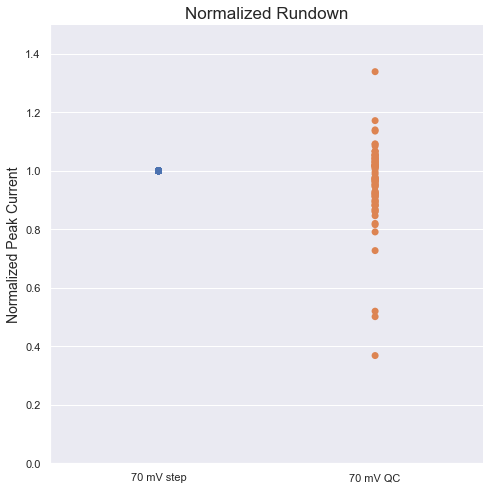

In [79]:
#fig, ax = plt.subplots(figsize=(10,10))
sns.catplot(x="peak", y="peak_value", jitter=False, data=norm, height =7, s=7, ci='sd')
plt.title("Normalized Rundown", fontsize= 17, loc = "center")
plt.ylabel("Normalized Peak Current", fontsize= 14)
plt.xlabel("", fontsize= 14)
#plt.gcf().subplots_adjust(top=0.92)
plt.ylim(0, 1.5)
#plt.xlim(1, 6)
plt.savefig("C:/users/lindsayn/documents/github/analysis/figures/normalized_rundown")

In [84]:
rundown_data['peak_2'].mean() / rundown_data['peak_1'].mean()


0.96552354688394948